In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# Hyperparameters
batch_size = 64
num_epochs = 3
learning_rate = 0.001

In [3]:
# Transformations for the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for ResNet
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize images
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:12<00:00, 13267052.21it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Load pretrained ResNet-50
model = torchvision.models.resnet50(pretrained=True)

# Replace the classifier head
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)  # 10 classes for CIFAR-10
# Freeze the backbone
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final layer
for param in model.fc.parameters():
    param.requires_grad = True
# Move model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]


In [5]:
from functools import total_ordering
# Fine-tuning the model
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    train_loss_list = []
    train_accuracy_list = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        total = 0
        correct = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        train_accuracy_list.append(accuracy)
        train_loss_list.append(running_loss / len(train_loader))
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')
    return train_loss_list,train_accuracy_list

In [6]:
# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

In [7]:
# Training and evaluation
train_loss_list, train_accuracy_list = train_model(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/3], Loss: 0.7595
Epoch [2/3], Loss: 0.5923
Epoch [3/3], Loss: 0.5654


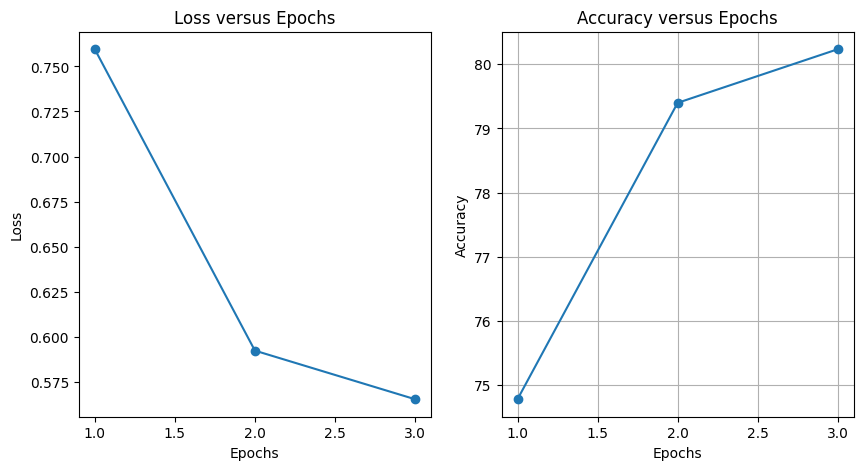

In [8]:
# Plotting the accuracy curves
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.plot(range(1, num_epochs + 1), train_loss_list, marker='o')
ax1.set_title('Loss versus Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

ax2.plot(range(1, num_epochs + 1), train_accuracy_list, marker='o')
ax2.set_title('Accuracy versus Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

plt.grid()
plt.show()

In [9]:
evaluate_model(model, test_loader)

Accuracy of the model on the test images: 81.96%
